We can write the neuron dynamic as

$$\tau_m \dot{V} = -V + I$$

and

$$\tau_s \dot{I} = I$$

If we assume initial conditions $I_0$ and $V_0$, this leads to the following dynamics for I:

$$I(t) = I_0e^{-\frac{t}{\tau_s}}$$

Guessing a solution of the form

$$v(t) = Ae^{-\frac{t}{\tau_s}} + Be^{-\frac{t}{\tau_m}}$$

for v, leads to

$$A = \frac{\tau_s}{\tau_s - \tau_m}I_0$$

Solving for the initial conditions

$$v(0) = A + B \stackrel{!}{=} V_0$$

leads to

$$B = V_0 - A = V_0 - \frac{\tau_s}{\tau_s - \tau_m}I_0$$

We can thus write the LIF dynamics as

$$v(t) = \frac{\tau_s}{\tau_s - \tau_m}I_0e^{-\frac{t}{\tau_s}} + (V_0 - \frac{\tau_s}{\tau_s - \tau_m}I_0)e^{-\frac{t}{\tau_m}}$$

which can be rewritten as 

$$v(t) = V_0e^{-\frac{t}{\tau_m}} + \frac{\tau_s}{\tau_m - \tau_s}I_0(e^{-\frac{t}{\tau_m}} - e^{-\frac{t}{\tau_s}})$$

Solving for the spike time T for the special case $\tau_m = 2\tau_s$, we get

$$\vartheta = V_0e^{-\frac{T}{\tau_m}} + I_0(e^{-\frac{T}{\tau_m}} - e^{-\frac{2T}{\tau_m}})$$

The quadratic nature now becomes apparent:

$$0 = -I_0(e^{-\frac{T}{\tau_m}})^2 + (V_0 + I_0)e^{-\frac{T}{\tau_m}} - \vartheta$$

Identifying $a_1 = I_0$ and $a_2 = V_0 + I_0$, we get

$$\frac{T}{\tau_m} = \log(\frac{2a_1}{a_2 + \sqrt{a_2^2 - 4a_1\vartheta}})

In [3]:
import jax.numpy as np
import jax
from functools import partial
import matplotlib.pyplot as plt

tau_mem = 1e-3
tau_syn = 5e-4

tau_mem_inv = 1 / tau_mem
tau_syn_inv = 1 / tau_syn
v_th = 0.3

def dynamic(state, t):
    """This holds for any tau_syn and tau_mem"""
    v_0, i_0 = state
    i = np.exp(-t/tau_syn)
    tau_frac = (tau_syn / (tau_syn - tau_mem))
    v = tau_frac * i_0 * np.exp(-t/tau_syn) + (v_0 - tau_frac * i_0) * np.exp(-t/tau_mem)
    return np.array([v, i])

def spike_time(state):
    assert tau_mem == 2 * tau_syn
    v_0, i_0 = state
    a_1 = i_0
    a_2 = v_0 + i_0
    T = tau_mem * np.log(2*a_1 / (a_2 + np.sqrt(a_2**2 - 4*a_1 * v_th)))
    return T

In [46]:
A = np.array([[-tau_mem_inv, tau_mem_inv], [0,-tau_syn_inv]])

def f(x0, t):
  return np.dot(jax.scipy.linalg.expm(A * t), x0)

[0.29999995 0.6662278 ]


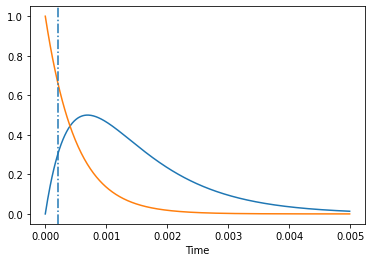

In [47]:
initial_state = np.array([0.0, 2.0])
times = np.arange(0, 0.005, 1e-5)
state = jax.vmap(jax.jit(partial(dynamic, initial_state)))(times)

t_spike = spike_time(initial_state)
spike_voltage = dynamic(initial_state, t_spike)
print(spike_voltage)
plt.xlabel("Time")
plt.plot(times, state)
plt.axvline(t_spike, linestyle='-.')
plt.show()

In [48]:
# compare the speed of both implementations
def dynamic(state, t):
    """This holds for any tau_syn and tau_mem"""
    i = np.exp(-t/tau_syn)
    tau_frac = (tau_syn / (tau_syn - tau_mem))
    v = tau_frac * state[1] * np.exp(-t/tau_syn) + (state[0] - tau_frac * state[1]) * np.exp(-t/tau_mem)
    return np.array([v, i])


f1 = jax.jit(jax.vmap(partial(dynamic, initial_state)))
f2 = jax.jit(jax.vmap(partial(f, initial_state)))
a = f1(times)
b = f2(times)
%timeit f1(times).block_until_ready()
%timeit f2(times).block_until_ready()

4.82 µs ± 54.9 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
57.1 µs ± 373 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


We see that our custom implementation is one magnitude faster

In [7]:
batched_dynamic = jax.vmap(dynamic, in_axes=(0, None))
batched_solver = jax.vmap(spike_time)

In [8]:
# check gradients
def loss_fn(weights):
    state = np.zeros((n_neurons, 2))
    state = batched_dynamic(state, 1e-4)

    # first input spike
    state = state.at[:, 1].set(state[:, 1] + weights[0, :])
    state = batched_dynamic(state, 2e-4)

    state = state.at[:, 1].set(state[:, 1] + weights[1, :])
    next_spike = batched_solver(state)[3]
    return (0.0002 - next_spike / tau_mem) ** 2


n_neurons = 4
rng = jax.random.PRNGKey(42)
weights = jax.random.uniform(rng, (n_neurons, n_neurons))

loss = []
for i in range(10):
    value, grad = jax.value_and_grad(loss_fn)(weights)
    loss.append(value)
    weights = weights - 0.1 * grad

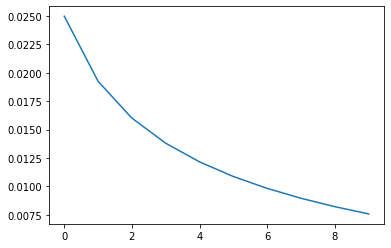

In [9]:
import matplotlib.pyplot as plt

plt.plot(np.arange(len(loss)), loss)
plt.show()

In [10]:
# Here we show the gradient problem
weights = np.array(
    [
        [0.0, 0.5, 1.0],
        [0.4, 0.0, 1.1],
        [0.4, 0.1, 0.0],
    ]
)
voltage = np.zeros(3)
spikes = np.array([1, 1, 0])

tau_mem = 1e-3
tau_syn = 5e-4

v_th = 0.3

from jax.config import config

config.update("jax_debug_nans", False)

def spike_time(state):
    v_0, i_0 = state
    a_1 = i_0
    a_2 = v_0 + i_0
    has_spike = a_2**2 - 4*a_1 * v_th > 0
    true_fun = lambda: tau_mem * np.log(2*a_1 / (a_2 + np.sqrt(a_2**2 - 4*a_1 * v_th)))
    false_fun = lambda: np.nan
    return jax.lax.cond(has_spike, true_fun, false_fun)

batched_spike_time = jax.vmap(spike_time)

def loss(weights):
    current = np.matmul(spikes, weights)
    state = np.stack((voltage, current), axis=1)
    return spike_time(state[2])


def loss2(weights):
    current = np.matmul(spikes, weights)
    state = np.stack((voltage, current), axis=1)
    return batched_spike_time(state)[2]

# loss2(weights)
print(jax.grad(loss)(weights))
print(jax.grad(loss2)(weights))

[[ 0.         0.        -0.0001256]
 [ 0.         0.        -0.0001256]
 [ 0.         0.        -0.       ]]
[[ 0.         0.        -0.0001256]
 [ 0.         0.        -0.0001256]
 [ 0.         0.        -0.       ]]
